# Workshop 4 -- Transfer Learning -- Base Model

We will train a generic deep neural network (DNN) to recognize the type of activity based on a given set of accelerometer data from a mobile device. We will use the HAPT data set for this tutorial ([HAPT = Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based%20Recognition%20of%20Human%20Activities%20and%20Postural%20Transitions#)). The data set comprises a collection of accelerometer data taken from a smartphone that various study participants carried with them while conducting six activities (Walking, Walking Upstairs, Walking Downstairs, Standing, Sitting, Lying). All participants were wearing a smartphone (Samsung Galaxy S II) on the waist during the experiment execution. Captured 3-axial linear acceleration and 3-axial angular velocity are at a constant rate of 50Hz using the embedded accelerometer and gyroscope of the device. The data set provides raw data and cleaned extracted features. In this workshop we will be using raw data. With this data we would like to train a simple neural network in order to understand if a person carrying a smartphone is performing any of the six activities (and six activity transitions). Once the neural network has been trained on this existing data, it should be able to correctly predict the type of activity a person is conducting.

We first change to a particular version of TensorFlow, which is later supported with on-device transfer learning. 


In [1]:
!pip install tensorflow==2.0.0rc0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 86.3MB 50kB/s 
     |████████████████████████████████| 4.3MB 45.1MB/s 
     |████████████████████████████████| 501kB 46.6MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
2.0.0-rc0


## Human Activity Recognition (HAPT) Data set

First, we download the data set and store it locally (if you reset the runtime for this Jupyter Notebook, the file will be removed and you will have to download it again).

In [2]:
!wget https://github.com/osaukh/mobile_computing_lab/raw/master/data/HAPT_Data_Set.zip
!unzip HAPT_Data_Set.zip

--2021-04-25 13:51:18--  https://github.com/osaukh/mobile_computing_lab/raw/master/data/HAPT_Data_Set.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osaukh/mobile_computing_lab/master/data/HAPT_Data_Set.zip [following]
--2021-04-25 13:51:18--  https://raw.githubusercontent.com/osaukh/mobile_computing_lab/master/data/HAPT_Data_Set.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78226634 (75M) [application/zip]
Saving to: ‘HAPT_Data_Set.zip’

HAPT_Data_Set.zip   100%[===================>]  74.60M  72.2MB/s    in 1.0s    

2021-04-25 13:51:19 (72.2 MB/s) - ‘HAPT_Data_Set.zip’ saved [782266

## Data Exploration

First we need to import all necessary Python libraries.

In [4]:
import os
import re

import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import np_utils

All activities in the HAPT data set.

In [5]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 
          'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 
          'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

Aggregate raw data from different files stored separately for each participant in the HAPT data set.

In [9]:
column_names=['experiment', 'user', 'activity', 'start', 'end']
df_labels = pd.read_csv('HAPT_Data_Set/RawData/labels.txt', header=None, names=column_names, delimiter=' ')

df = pd.DataFrame()
column_names = ['x-axis','y-axis','z-axis']
for f in os.listdir('HAPT_Data_Set/RawData/.'):
  if f.startswith('acc'):
    [e, u] = [int(s) for s in re.findall(r'-?\d+', str(f))]
    # print('e=%i, u=%i' % (e,u))
    dft = pd.read_csv('HAPT_Data_Set/RawData/'+f, header=None, names=column_names, delimiter=' ')
    dft['user-id'] = u
    dftt = df_labels[df_labels['experiment'] == e]
    dftt = dftt[dftt['user'] == u]
    for idx,row in dftt.iterrows():
      dtc = dft[dft.index>=row.start]
      dtc = dtc[dtc.index<row.end]
      dtc['activity'] = row.activity
      df = df.append(dtc, ignore_index=True)

print('Number of rows / columns in train: %i / %i' % (df.shape[0], df.shape[1]))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of rows / columns in train: 814400 / 5


,x-axis,y-axis,z-axis,user-id,activity
0,1.015278,-0.200000,-0.150000,13,5
1,0.961111,-0.187500,-0.118056,13,5
2,0.926389,-0.200000,-0.098611,13,5
3,1.022222,-0.188889,-0.083333,13,5
4,1.009722,-0.206944,-0.166667,13,5


Plot statistics on the number of data points.

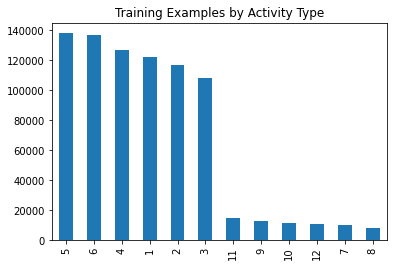

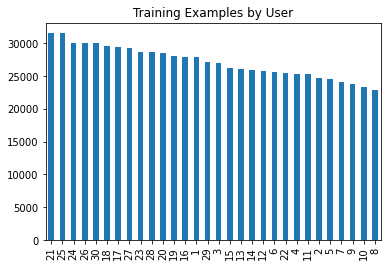

In [10]:
# Show how many training examples exist for each activity
df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different users
df['user-id'].value_counts().plot(kind='bar', title='Training Examples by User')
plt.show()

As we can see, we have more data for activities than for transitions between them. Also we can see that 30 persons have participated in the study. Next, let's take a look at the accelerometer data for each of the three axis for all activities. The data is recorded at a sampling rate of 50 Hz (50 values per second). Since we show the first 500 records, each chart shows a 10 second interval for each activity.

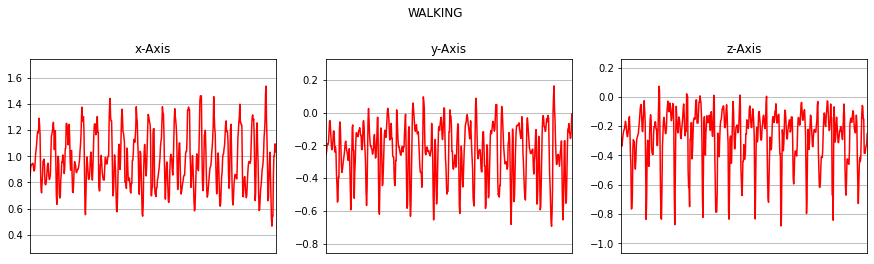

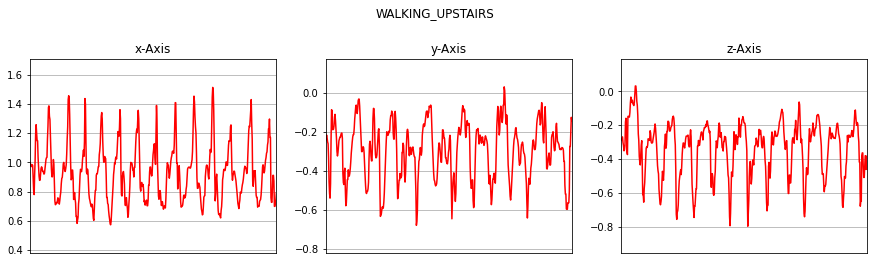

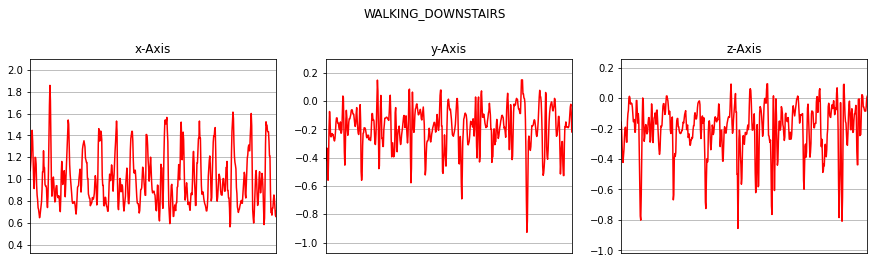

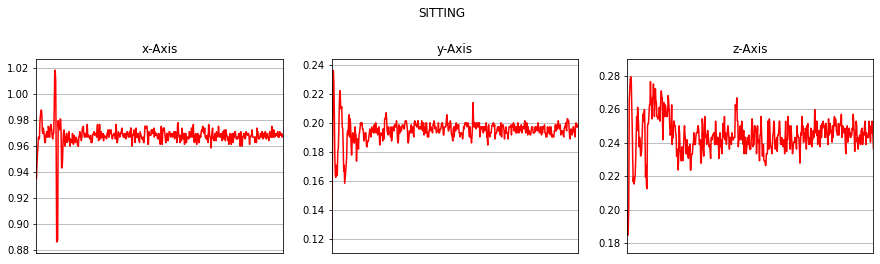

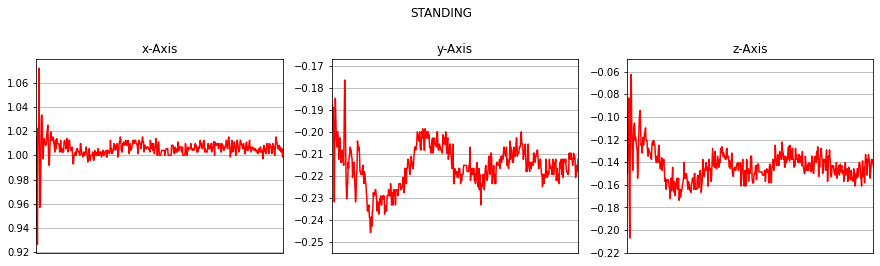

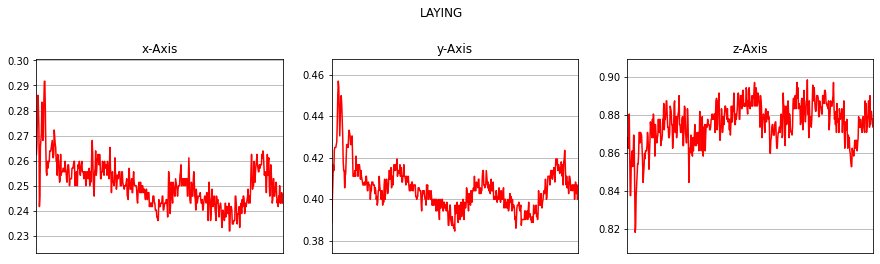

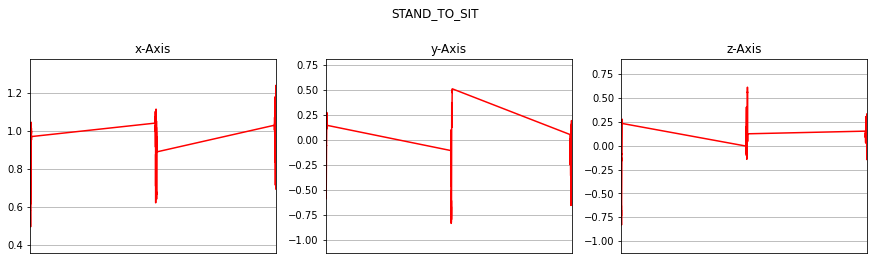

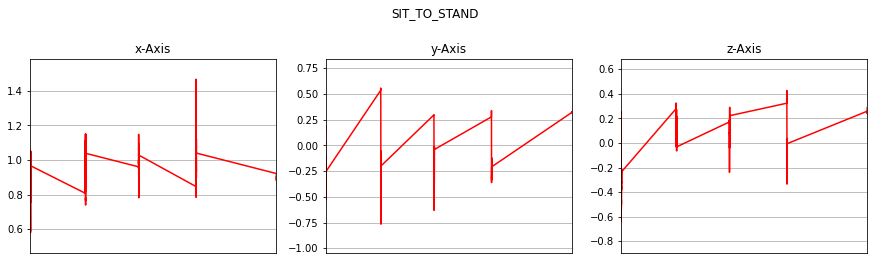

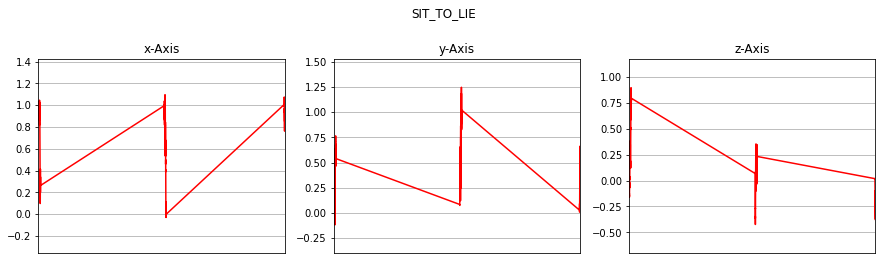

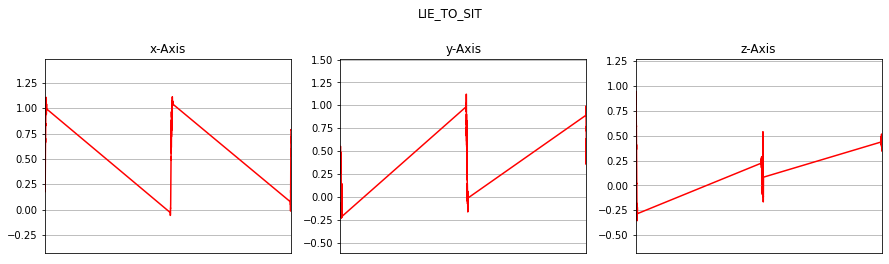

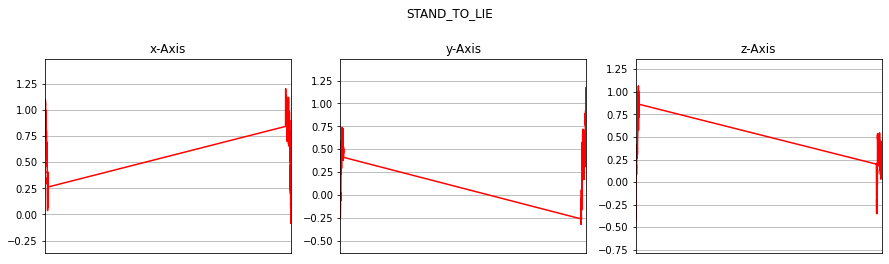

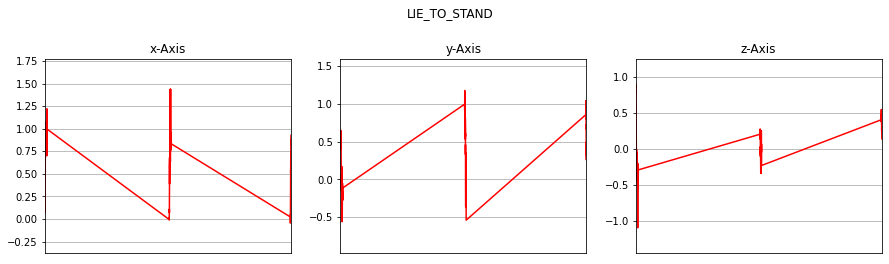

In [11]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,
         figsize=(15, 4),
         sharex=True)
    plot_axis(ax0, data.index, data['x-axis'], 'x-Axis')
    plot_axis(ax1, data.index, data['y-axis'], 'y-Axis')
    plot_axis(ax2, data.index, data['z-axis'], 'z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(LABELS[activity-1])
    plt.subplots_adjust(top=0.8)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:500]
    plot_activity(activity, subset)

As expected, there is a higher acceleration for activities such as walking compared to sitting.

## Data Preprocessing

It is important to separate the whole data set into a training set and a test set. We want our neural network to learn from a few persons which have been through the experiment and see how well our model predicts for persons it has not seen before.

Let's split based on the user IDs. We will keep users with ID 1 to 20 for training the model and users with ID greater than 20 for the test set.

In [33]:
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df['activity'] = le.fit_transform(df['activity'].values.ravel())


# Differentiate between test set and training set
df_test = df[df['user-id'] > 20]
df_train = df[df['user-id'] <= 20]

Next, we need to normalize the features within our training data. There are various ways on how to normalize. Keep in mind to use the same normalization  later when feeding new data into the model. Otherwise the preditions will be off. On top of the normalization we also decided to round the three features to six digits. You can play around with the optimal number here in order to further increase the performance of your network.

In [34]:
# Normalize features for training data set
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let's create another function for this called create_segments_and_labels. This function will take in the dataframe and the label names as well as the length of each record. In our case, let's go with 200 steps. Taking into consideration the 50 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.02 * 200 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

In [35]:
# The number of steps within one time segment
TIME_PERIODS = 200
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 100

def create_segments_and_labels(df, time_steps, step, label_name):
    N_FEATURES = 3 # x, y, z acceleration as features
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS,STEP_DISTANCE,LABEL)

By now, you should have both 5.217 records in x_train as well as in y_train. Each of the 5.217 records in x_train is a two dimensional matrix of the shape 200x3.

In [36]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (5217, 200, 3)
5217 training samples
y_train shape:  (5217,)


For constructing our deep neural network, we should now store the following dimensions:
*    Number of time periods: This is the number of time periods within one record (since we wanted to have a 2 second time interval, this number is 100 in our case)
*    Number of sensors: 3 -- we only use the acceletion over the x, y, and z axis
*    Number of classes: 12 -- the number of nodes for our output layer in the neural network.


In [37]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


The data that we would like to feed into our network is 2-dimensional (200x3). We flatten the data for our input layer into the neural network. Instead of feeding a matrix of shape 200x3 we will feed in a list of 600 values.

In [39]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (5217, 600)
input_shape: 600


Before continuing, we need to convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.

In [40]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

We are almost done with the preparation of our data. One last step we need to do is to conduct [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot) of our labels. Please only execute this line once!

In [41]:
from tensorflow.keras.utils import to_categorical

y_train_hot = to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (5217, 12)


## Building and Training a Model

By now, you have completed all the heavy-lifting on your side. The data is ready in such a format that Keras will be able to process it. I have decided to create a neural network with 3 hidden layers of fully connected nodes each (feel free to play around with the shape of the network or even switch to more complex ones like a convolutional neural network).

In [42]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(32, activation='relu'))
model_m.add(Dropout(.2))
model_m.add(Dense(16, activation='relu'))
model_m.add(Dense(8, activation='relu', name="headlayer"))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 200, 3)            0         
_________________________________________________________________
dense (Dense)                (None, 200, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 200, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 16)           528       
_________________________________________________________________
headlayer (Dense)            (None, 200, 8)            136       
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1

Next, we will fit / train the model with our training data that we have prepared earlier. We will define an early stopping callback monitor on training accuracy: if the training fails to improve for two consecutive epochs, then the training will stop with the best model. The hyperparameter used for the training are quite simple: We will use a batch size of 400 records and will train the model for 50 epochs. For model training, we will use a 80:20 split to separate training data and validation data. Let's go ahead and train the model. There are some good explanations out there on the different hyperparameters, for instance [here](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9).

In [43]:
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train, y_train_hot, batch_size=BATCH_SIZE, epochs=EPOCHS,
                      validation_split=0.2, verbose=1)

Train on 4173 samples, validate on 1044 samples
Epoch 1/50
4173/4173 [==============================] - 2s 423us/sample - loss: 2.1082 - accuracy: 0.2902 - val_loss: 1.7537 - val_accuracy: 0.4138
Epoch 2/50
4173/4173 [==============================] - 1s 204us/sample - loss: 1.6613 - accuracy: 0.3925 - val_loss: 1.5927 - val_accuracy: 0.4617
Epoch 3/50
4173/4173 [==============================] - 1s 209us/sample - loss: 1.5065 - accuracy: 0.4582 - val_loss: 1.4532 - val_accuracy: 0.5096
Epoch 4/50
4173/4173 [==============================] - 1s 207us/sample - loss: 1.3826 - accuracy: 0.4680 - val_loss: 1.3484 - val_accuracy: 0.5105
Epoch 5/50
4173/4173 [==============================] - 1s 207us/sample - loss: 1.2918 - accuracy: 0.4874 - val_loss: 1.2639 - val_accuracy: 0.5010
Epoch 6/50
4173/4173 [==============================] - 1s 210us/sample - loss: 1.2359 - accuracy: 0.4965 - val_loss: 1.2149 - val_accuracy: 0.5029
Epoch 7/50
4173/4173 [==============================] - 1s 210us

The performance of this simple DNN is OK. We have validation accuracy of approximately 75%. This could definitely be improved - maybe with further hyperparameter tuning and especially with a modified neural network design. Before we go on with the test validation, we will print the learning curve for both the training and validation data set.

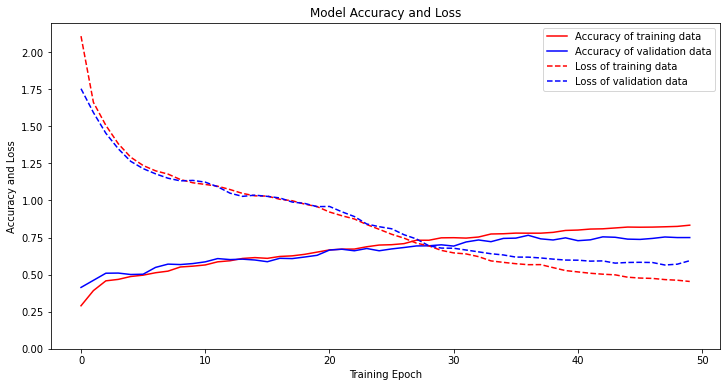

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76       813
         1.0       0.76      0.91      0.83       758
         2.0       0.82      0.75      0.78       708
         3.0       0.87      0.65      0.75       780
         4.0       0.72      0.92      0.81       861
         5.0       0.98      0.99      0.98       843
         6.0       0.75      0.51      0.61        65
         7.0       0.81      0.60      0.69        58
         8.0       0.63      0.86      0.73        85
         9.0       0.75      0.88      0.81        73
        10.0       0.87      0.45      0.59       103
        11.0       0.92      0.67      0.78        70

    accuracy                           0.81      5217
   macro avg       0.81      0.74      0.76      5217
weighted avg       0.82      0.81      0.81      5217



In [44]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

Let's continue with this model and see how it performs against the test data that we have held back earlier. In our case, we will check the performance against the movements of the six users that the model has not yet seen.

In [45]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=0)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


Accuracy on test data: 0.77

Loss on test data: 0.61


The accuracy on the test data is 77%. This means that our model generalizes well for persons it has not yet seen. Let's see where our model wrongly predicted the labels.

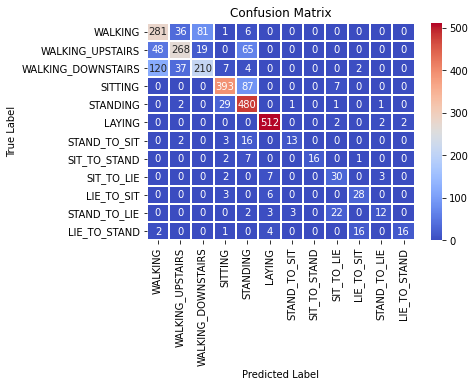

              precision    recall  f1-score   support

           0       0.62      0.69      0.66       405
           1       0.78      0.67      0.72       400
           2       0.68      0.55      0.61       380
           3       0.89      0.81      0.85       487
           4       0.72      0.93      0.81       514
           5       0.96      0.99      0.98       518
           6       0.76      0.38      0.51        34
           7       1.00      0.62      0.76        26
           8       0.48      0.71      0.58        42
           9       0.60      0.76      0.67        37
          10       0.67      0.29      0.40        42
          11       0.89      0.41      0.56        39

    accuracy                           0.77      2924
   macro avg       0.75      0.65      0.67      2924
weighted avg       0.78      0.77      0.77      2924



In [46]:
import seaborn as sns

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

As you can see, the precision of the model is good for predicting sitting, standing and lying. The model has problems to clearly identify upstairs and downstairs activities. There is of course still great potential for improving the model. We further store the model on the Google Drive. First, mount the Drive.

In [48]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
# Save the model
model_m.save('/content/gdrive/My Drive/MCL/WS04/saved_model.pbtxt')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/MCL/WS04/saved_model.pbtxt/assets


## TFLite Conversion

Now let's convert the model to the TF Lite format.

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras import layers

In [51]:
# Load the model
model = load_model('/content/gdrive/My Drive/MCL/WS04/saved_model.pbtxt')

You can experiment with different optimization options and see how they impact the size and the accuracy of the resulting model.

In [52]:
# Convert the model with TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

tflite_model = converter.convert()
open("/content/gdrive/My Drive/MCL/WS04/converted_model.tflite", "wb").write(tflite_model)

26432

Check the converted TF Lite model: Load the model and use the TF Lite python interpreter to verify the results. We compare the output of the predictions of the "model" (unconverted TF model) and "tflite_model" (TF Lite model with optimizations) on the test data. Change the "decimal" to see for which one the models agree.

In [53]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
  expected = model.predict(x_test[i:i+1])
  interpreter.set_tensor(input_details[0]["index"], x_test[i:i+1, :])
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]["index"])

  # Assert if the result of TFLite model is consistent with the TF model.
  np.testing.assert_almost_equal(expected, result, decimal=3)
  print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

  # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
  # the states.
  # Clean up internal states.
  interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.


## Credits

*   Some parts of this workshop are based on:
[Human Activity Recognition Tutorial with Keras and CoreML (Part 1)](https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb)